In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

random_state = 42

In [2]:
from investment_system.data_utils import get_multimodal_data

(X_numerical_train, y_numerical_train, X_numerical_val, y_numerical_val, X_numerical_test, y_numerical_test,
            X_textual_train, y_textual_train, X_textual_val, y_textual_val, X_textual_test, y_textual_test) = get_multimodal_data(drop_all_columns=True)

In [3]:
decisionTreeClassifier = DecisionTreeClassifier(random_state=random_state,
                                                min_samples_split=2,
                                                min_samples_leaf=1,
                                                max_depth=10,
                                                criterion='entropy',
                                                class_weight={True: 30, False: 1})

decisionTreeClassifier.fit(X_numerical_train, y_numerical_train)

y_pred = decisionTreeClassifier.predict(X_numerical_test)

print(f"Test Accuracy: {accuracy_score(y_numerical_test, y_pred)}")
print(f"Test Precision: {precision_score(y_numerical_test, y_pred)}")
print(f"Test Recall: {recall_score(y_numerical_test, y_pred)}")

Test Accuracy: 0.9808259587020649
Test Precision: 0.4166666666666667
Test Recall: 0.45454545454545453


In [4]:
tf_idf_vectorizer = TfidfVectorizer(max_features=1000)

X_textual_train_features = tf_idf_vectorizer.fit_transform(X_textual_train['text'].values)
X_textual_test_features = tf_idf_vectorizer.transform(X_textual_test['text'].values)

In [6]:
kNeighborsClassifier = KNeighborsClassifier(weights='uniform', p=2, n_neighbors=7, leaf_size=10, algorithm='brute')

kNeighborsClassifier.fit(X_textual_train_features, y_textual_train)

y_pred = kNeighborsClassifier.predict(X_textual_test_features)

accuracy = accuracy_score(y_textual_test, y_pred)
precision = precision_score(y_textual_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")

Accuracy: 0.9852507374631269
Precision: 1.0


### Hybrid model

In [7]:
from investment_system.data_utils import get_multimodal_data

(X_numerical_train, y_numerical_train, X_numerical_val, y_numerical_val, X_numerical_test, y_numerical_test,
            X_textual_train, y_textual_train, X_textual_val, y_textual_val, X_textual_test, y_textual_test) = get_multimodal_data(drop_all_columns=True)

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import numpy as np

def get_trained_models(X_numerical_train, y_numerical_train, X_textual_train, y_textual_train, random_state):
    decisionTreeClassifier = DecisionTreeClassifier(
        random_state=random_state,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=10,
        criterion='entropy',
        class_weight={True: 30, False: 1}
    )
    decisionTreeClassifier.fit(X_numerical_train, y_numerical_train)

    kNeighborsClassifier = KNeighborsClassifier(weights='uniform', p=2, n_neighbors=7, leaf_size=10, algorithm='brute')
    kNeighborsClassifier.fit(X_textual_train, y_textual_train)

    return decisionTreeClassifier, kNeighborsClassifier

# 
# tf_idf_vectorizer = TfidfVectorizer(max_features=1000)
# 
# decisionTreeClassifier, kNeighborsClassifier = get_trained_models(X_numerical_train, y_numerical_train, X_textual_train, y_textual_train, tf_idf_vectorizer, random_state)
# 
# y_pred_decisionTreeClassifier = decisionTreeClassifier.predict(X_numerical_test)
# 
# accuracy = accuracy_score(y_numerical_test, y_pred_decisionTreeClassifier)
# precision = precision_score(y_numerical_test, y_pred_decisionTreeClassifier)
# 
# print(f"DecisionTreeClassifier: Accuracy: {accuracy:.4f}, Precision: {precision:.4f}")
# 
# X_textual_test_features = tf_idf_vectorizer.transform(X_textual_test['text'].values)
# y_pred_ada_boost_classifier = kNeighborsClassifier.predict(X_textual_test_features)
# 
# accuracy = accuracy_score(y_textual_test, y_pred_ada_boost_classifier)
# precision = precision_score(y_textual_test, y_pred_ada_boost_classifier)
# 
# print(f"AdaBoostClassifier: Accuracy: {accuracy:.4f}, Precision: {precision:.4f}")

In [8]:
def predict_hybrid(X_numerical, X_textual, decisionTreeClassifier, kNeighborsClassifier, decisionTreeClassifier_weight=0.2, kNeighborsClassifier_weight=0.8):
    numerical_preds = decisionTreeClassifier.predict_proba(X_numerical)[:, 1]
    textual_preds = kNeighborsClassifier.predict_proba(X_textual)[:, 1]

    final_preds = decisionTreeClassifier_weight * numerical_preds + kNeighborsClassifier_weight * textual_preds
    final_preds = final_preds > 0.5
    
    return final_preds

# final_test_preds = predict_hybrid(X_numerical_test, X_textual_test_features, decisionTreeClassifier, kNeighborsClassifier)
# accuracy = accuracy_score(y_numerical_test, final_test_preds)
# precision = precision_score(y_numerical_test, final_test_preds)
# print(f"Hybrid Model Accuracy: {accuracy:.4f}")
# print(f"Hybrid Model Precision: {precision:.4f}")

In [8]:
decisionTreeClassifier_weights = np.linspace(0, 1, 11)
kNeighborsClassifier_weights = 1 - decisionTreeClassifier_weights

In [9]:
kNeighborsClassifier_weights

array([1. , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0. ])

In [9]:
accuracies = []
precisions = []

accuracies_meaned = []
precisions_meaned = []

tf_idf_vectorizer = TfidfVectorizer(max_features=1000)

X_textual_train_features = tf_idf_vectorizer.fit_transform(X_textual_train['text'].values)
X_textual_test_features = tf_idf_vectorizer.transform(X_textual_test['text'].values)

for decisionTreeClassifier_weight, kNeighborsClassifier_weight in tqdm(zip(decisionTreeClassifier_weights, kNeighborsClassifier_weights)):
    
    random_state = 42
    accuracies = []
    precisions = []
    
    for i in range(3):
        
        decisionTreeClassifier, kNeighborsClassifier = get_trained_models(X_numerical_train, y_numerical_train,
                                                                          X_textual_train_features, y_textual_train,
                                                                          random_state+i)
    
        final_test_preds = predict_hybrid(X_numerical_test, X_textual_test_features,
                                          decisionTreeClassifier, kNeighborsClassifier,
                                          decisionTreeClassifier_weight, kNeighborsClassifier_weight)
        
        accuracy = accuracy_score(y_numerical_test, final_test_preds)
        precision = precision_score(y_numerical_test, final_test_preds)
        # print(f"Hybrid Model Accuracy: {accuracy:.4f}")
        # print(f"Hybrid Model Precision: {precision:.4f}")
        
        accuracies.append(accuracy)
        precisions.append(precision)
        
        del decisionTreeClassifier
        del kNeighborsClassifier
        
    
    accuracies_meaned.append(np.mean(accuracies))
    precisions_meaned.append(np.mean(precisions))
    
print(f"Accuracies: {accuracies_meaned}")
print(f"Precisions: {precisions_meaned}")

print(f"Mean Accuracy: {np.mean(accuracies_meaned)}")
print(f"Mean Precision: {np.mean(precisions_meaned)}")
        
#     final_test_preds = decisionTreeClassifier_weight * numerical_test_preds + adaBoostClassifier_weight * textual_test_preds
# 
#     final_test_preds = final_test_preds > 0.5
# 
#     # Evaluate accuracy
#     accuracy = accuracy_score(y_numerical_test, final_test_preds)
#     precision = precision_score(y_numerical_test, final_test_preds)
#     
#     accuracies.append(accuracy)
#     precisions.append(precision)
#     
# print(f"Mean Accuracy: {np.mean(accuracies)}")
# print(f"Mean Precision: {np.mean(precisions)}")



0it [00:00, ?it/s]C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\neighbors\_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\neighbors\_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\neighbors\_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
1it [00:01,  1.05s/it]C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\neighbors\_base.py:583: UserWarning: cannot use tree w

Accuracies: [0.9852507374631269, 0.9852507374631269, 0.9852507374631269, 0.9852507374631269, 0.9867256637168141, 0.9862340216322517, 0.9788593903638151, 0.9773844641101279, 0.9773844641101279, 0.9773844641101279, 0.9773844641101279]
Precisions: [1.0, 1.0, 1.0, 1.0, 1.0, 0.7000000000000001, 0.3651903651903652, 0.33669108669108666, 0.33669108669108666, 0.33669108669108666, 0.33669108669108666]
Mean Accuracy: 0.9820327165459908
Mean Precision: 0.6738140647231555


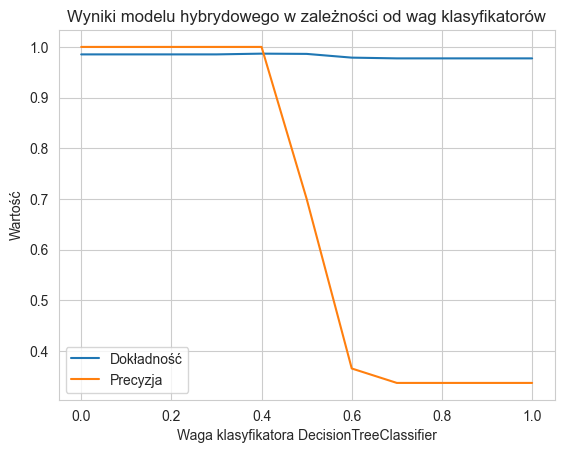

In [10]:
import matplotlib.pyplot as plt

plt.plot(decisionTreeClassifier_weights, accuracies_meaned, label='Dokładność')
plt.plot(decisionTreeClassifier_weights, precisions_meaned, label='Precyzja')
plt.xlabel('Waga klasyfikatora DecisionTreeClassifier')
plt.ylabel('Wartość')
plt.title('Wyniki modelu hybrydowego w zależności od wag klasyfikatorów')
plt.legend()
plt.show()